In [4]:
!pip install scikit-learn opencv-python matplotlib seaborn pandas numpy

  Using cached opencv_python-4.13.0.92-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------- ----------- 6.3/8.9 MB 32.1 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 29.0 MB/s  0:00:00
Using cached opencv_python-4.13.0.92-cp37-abi3-win_amd64.whl (40.2 MB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------------------ --------- 6.3/8.1 MB 29.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 21.0 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 27.4 MB/s  0:00:00
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
   -------------------------------

In [6]:
!pip install timm

  Using cached timm-1.0.24-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-1.4.1-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl.metadata (4.2 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl.metadata (5.0 kB)
  Using cached typer_slim-0.21.1-py3-none-any.whl.metadata (16 kB)
Using cached timm-1.0.24-py3-none-any.whl (2.6 MB)
Using cached huggingface_hub-1.4.1-py3-none-any.whl (553 kB)
Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl (2.9 MB)
Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl (341 kB)
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   -------------------- ------------------- 3.1/6.2 MB 14.1 MB/s eta 0:00:01
   ---------------------------------------- 6.2/6.2 MB 14.6 MB/s  0:00:00
Using cached typer_slim-0.21.1-py3-none-any.whl (47 kB)

  Attempting uninstall: sympy

    Found existing installation: sympy 1.14.0

   ---- -----------------------------------  1/10 [sympy]
   ---- 

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import timm


In [11]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.5.1
True
1


In [12]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


Torch version: 2.5.1
CUDA available: True
GPU count: 1
GPU name: NVIDIA GeForce RTX 4050 Laptop GPU


In [15]:
import shutil
import random
from pathlib import Path

In [23]:
SRC_DIR = "The IQ-OTHNCCD lung cancer dataset"

In [24]:
DEST_DIR = "lung_ct_split"

In [25]:
classes = ["Bengin cases", "Malignant cases", "Normal cases"]

In [26]:
split_ratio = (0.7,0.15,0.15)

In [27]:
for cls in classes:
    images = list(Path(os.path.join(SRC_DIR, cls)).glob("*"))
    random.shuffle(images)

    train_end = int(len(images) * split_ratio[0])
    val_end = train_end + int(len(images) * split_ratio[1])

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, files in splits.items():
        split_dir = os.path.join(DEST_DIR, split, cls)
        os.makedirs(split_dir, exist_ok=True)

        for f in files:
            shutil.copy(f, split_dir)

print("✅ Dataset split complete!")

✅ Dataset split complete!


In [30]:
DATA_DIR = r"lung_ct_split"
IMG_SIZE = 224
BATCH_SIZE = 8

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR,"train"), transform=transform)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

print("Classes:", train_dataset)
print("Total train images: ",len(train_dataset))

Classes: Dataset ImageFolder
    Number of datapoints: 767
    Root location: lung_ct_split\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Total train images:  767


In [29]:
for split in ["train", "val", "test"]:
    print(f"\n--- {split.upper()} ---")
    split_path = os.path.join(DATA_DIR, split)

    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        print(cls, "→", len(os.listdir(cls_path)), "files")


--- TRAIN ---
Bengin cases → 84 files
Malignant cases → 392 files
Normal cases → 291 files

--- VAL ---
Bengin cases → 18 files
Malignant cases → 84 files
Normal cases → 62 files

--- TEST ---
Bengin cases → 18 files
Malignant cases → 85 files
Normal cases → 63 files


In [32]:
import cv2 
import numpy as np

def apply_clahe(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def denoise(img):
    return cv2.GaussianBlur(img, (5,5), 0)

def preprocess_ct(image):
    img = np.array(image)
    img = apply_clahe(img)
    img = denoise(img)
    return img


In [33]:
class CTPreprocess:
    def __call__(self, image):
        image = preprocess_ct(image)
        return image

In [34]:
train_transform = transforms.Compose([
    CTPreprocess(),
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    CTPreprocess(),
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [35]:
train_transform

Compose(
    ToPILImage()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

In [36]:
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=test_transform)


In [43]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [37]:
class HybridModel(nn.Module):
    def __init__(self, num_classes = 3):
        super().__init__()

        self.cnn = timm.create_model("resnet50", pretrained=True, num_classes=0)

        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)

        cnn_features = self.cnn.num_features
        vit_features = self.vit.num_features

        self.classifier = nn.Sequential(
            nn.Linear(cnn_features + vit_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):
        f1 = self.cnn(x)
        f2 = self.vit(x)
        fused = torch.cat((f1,f2),dim=1)
        return self.classifier(fused)

model = HybridModel(num_classes=3).to(device)
print("Hybrid CNN-Transformer model ready")

C:\Users\navne\anaconda3\envs\lung_gpu\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\navne\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\navne\anaconda3\envs\lung_gpu\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: 

Hybrid CNN-Transformer model ready


In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2, verbose=True
)


C:\Users\navne\anaconda3\envs\lung_gpu\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [39]:
from sklearn.metrics import accuracy_score

def train_one_epoch(loader):
    model.train()
    running_loss = 0
    preds, labels_list = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds.extend(torch.argmax(outputs, 1).cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

    acc = accuracy_score(labels_list, preds)
    return running_loss / len(loader), acc


def validate(loader):
    model.eval()
    running_loss = 0
    preds, labels_list = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    acc = accuracy_score(labels_list, preds)
    return running_loss / len(loader), acc, preds, labels_list


In [44]:
EPOCHS = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):

    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc, _, _ = validate(val_loader)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")



Epoch 1/10
Train Loss: 0.5014 | Train Acc: 0.7992
Val   Loss: 0.6221 | Val   Acc: 0.7378

Epoch 2/10
Train Loss: 0.3548 | Train Acc: 0.8683
Val   Loss: 0.3568 | Val   Acc: 0.8476

Epoch 3/10
Train Loss: 0.3283 | Train Acc: 0.8540
Val   Loss: 0.2783 | Val   Acc: 0.9085

Epoch 4/10
Train Loss: 0.2720 | Train Acc: 0.8957
Val   Loss: 0.3610 | Val   Acc: 0.8598

Epoch 5/10
Train Loss: 0.2869 | Train Acc: 0.8866
Val   Loss: 0.7663 | Val   Acc: 0.7134

Epoch 6/10
Train Loss: 0.2871 | Train Acc: 0.8905
Val   Loss: 0.2651 | Val   Acc: 0.8720

Epoch 7/10
Train Loss: 0.2449 | Train Acc: 0.9100
Val   Loss: 0.2336 | Val   Acc: 0.8963

Epoch 8/10
Train Loss: 0.2066 | Train Acc: 0.9309
Val   Loss: 0.2380 | Val   Acc: 0.9268

Epoch 9/10
Train Loss: 0.1871 | Train Acc: 0.9361
Val   Loss: 0.2301 | Val   Acc: 0.9024

Epoch 10/10
Train Loss: 0.1589 | Train Acc: 0.9400
Val   Loss: 0.1980 | Val   Acc: 0.9268


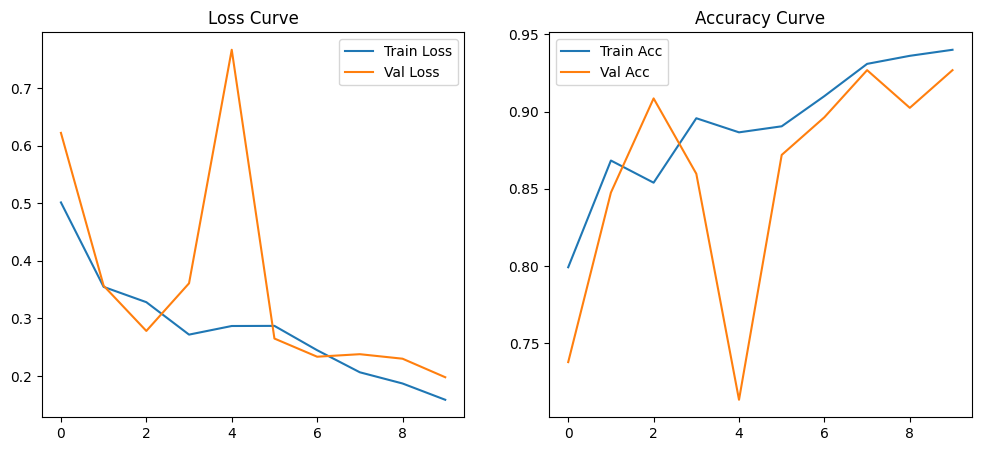

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

In [47]:
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['Bengin cases', 'Malignant cases', 'Normal cases']


In [50]:
test_loss, test_acc, preds, labels = validate(test_loader)

print("Test Accuracy:", test_acc)
print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=classes))

Test Accuracy: 0.9457831325301205

Classification Report:

                 precision    recall  f1-score   support

   Bengin cases       0.82      0.78      0.80        18
Malignant cases       1.00      0.98      0.99        85
   Normal cases       0.91      0.95      0.93        63

       accuracy                           0.95       166
      macro avg       0.91      0.90      0.91       166
   weighted avg       0.95      0.95      0.95       166



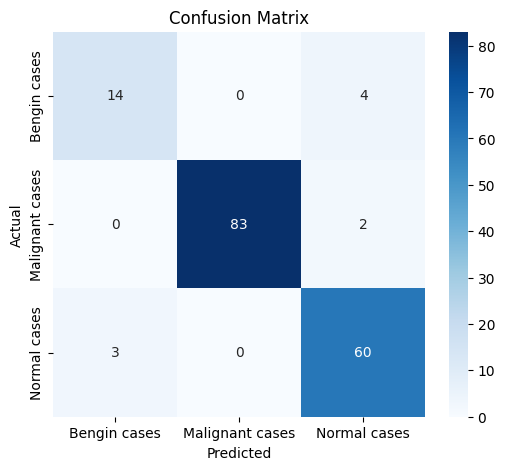

In [49]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [51]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        loss = output[:, class_idx]
        loss.backward()

        gradients = self.gradients[0]
        activations = self.activations[0]

        weights = torch.mean(gradients, dim=(1, 2))
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32).to(input_tensor.device)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.cpu().numpy(), class_idx


In [52]:
target_layer = model.cnn.layer4[-1]
gradcam = GradCAM(model, target_layer)

In [53]:
model.eval()

images, labels = next(iter(test_loader))
input_tensor = images[0].unsqueeze(0).to(device)

cam, pred_class = gradcam.generate(input_tensor)

print("Predicted class:", class_names[pred_class])
print("Actual class:", class_names[labels[0]])

C:\Users\navne\anaconda3\envs\lung_gpu\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class: Bengin cases
Actual class: Bengin cases


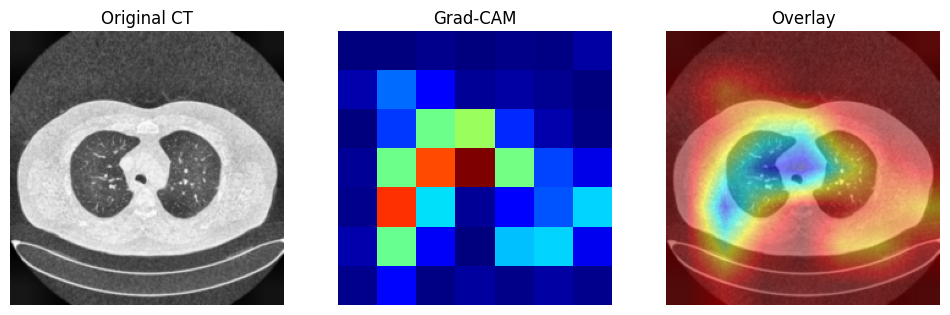

In [54]:
img = images[0].permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = heatmap / 255.0

overlay = heatmap * 0.5 + img * 0.5
overlay = np.clip(overlay, 0, 1)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original CT")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()